In [41]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [42]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


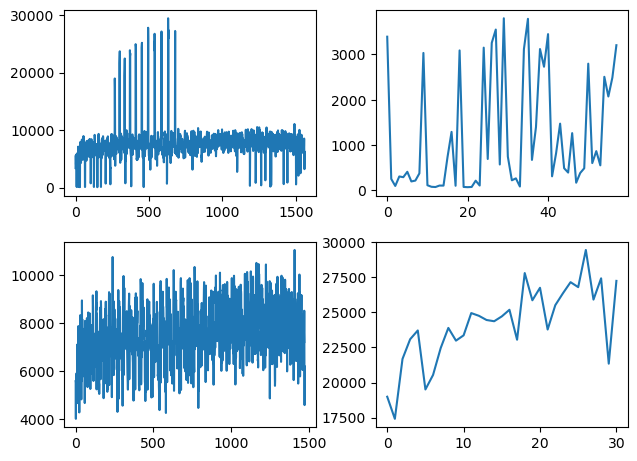

In [43]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [44]:
Resa3Medium = Resa3Medium/Resa3Medium.max()

1185


(array([ 1.,  4.,  3.,  4., 10., 14., 18., 23., 26., 28., 21., 12., 13.,
        20., 25., 19., 27., 33., 19., 33., 26., 24., 28., 18., 21., 23.,
        39., 44., 26., 19., 10.,  5.,  3.,  1.,  1.,  1.]),
 array([0.36391   , 0.38157916, 0.39924833, 0.4169175 , 0.43458664,
        0.45225582, 0.469925  , 0.48759416, 0.5052633 , 0.52293247,
        0.5406017 , 0.5582708 , 0.57594   , 0.59360915, 0.61127836,
        0.6289475 , 0.64661664, 0.66428584, 0.681955  , 0.6996242 ,
        0.7172933 , 0.7349625 , 0.75263166, 0.7703008 , 0.78797   ,
        0.80563915, 0.82330835, 0.8409775 , 0.8586467 , 0.87631583,
        0.893985  , 0.9116542 , 0.9293233 , 0.9469925 , 0.96466166,
        0.98233086, 1.        ], dtype=float32),
 <a list of 36 Patch objects>)

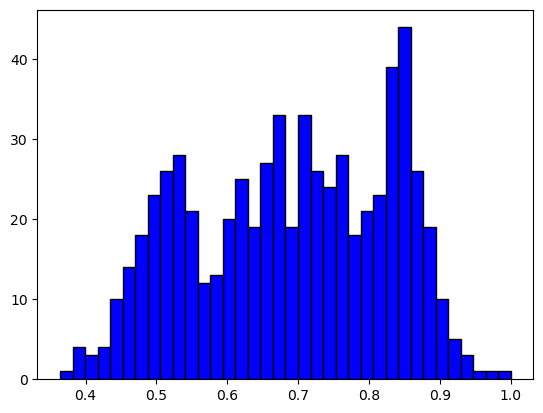

In [45]:
Resa3Undesampling = (Resa3Medium>=0.55) & (Resa3Medium<=0.83)

trueList = np.argwhere(Resa3Undesampling == True).flatten()
print(trueList.shape[0])
falseList = np.argwhere(Resa3Undesampling == False).flatten()
flipToFalse = np.random.choice(range(trueList.shape[0]), size=(int(trueList.shape[0]*0.3),), replace=False)

SampleList = np.concatenate((falseList,trueList[flipToFalse]))

Resa3Sampled = Resa3Medium[SampleList]
Pixel3Sampled = Pixel3Medium[SampleList,:,:]
import seaborn as sns
plt.hist(Resa3Sampled, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [46]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[0.52304775 0.42339116 0.5114244  0.5090383  0.48341468 0.5330803
 0.46571767 0.44168472 0.46571767 0.47682574]


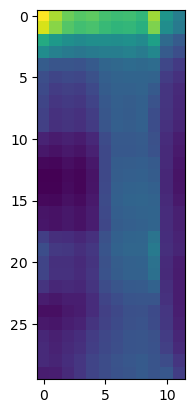

In [47]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Sampled,Resa3Sampled)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [48]:
print(training_setMediumX.shape)

(321, 12, 30)


In [49]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY
inputSize = (100,32)
# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = inputSize,
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = inputSize,
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

SyntaxError: invalid syntax (2049392978.py, line 4)

In [ ]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.6903212666511536
0.698481559753418
0.6924986839294434
0.6953859329223633


# Creazione del modello di Vgg16

In [ ]:
# Import model
vgg16 = VGG16(input_shape=inputSize+(3,),include_top=False)

# Import model
#vgg16 = VGG16()

In [ ]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16.layers)-1):
    vgg16Model.add(vgg16.layers[i])
vgg16Model.add(Flatten())

In [ ]:
# Close the layers of vgg16
for layers in vgg16Model.layers[:-3]:
    layers.trainable = False

In [ ]:
# Last layer
vgg16Model.add(Dense(2048,activation='relu'))
vgg16Model.add(Dense(1,activation='linear'))

In [ ]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 100, 32, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 32, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 8, 128)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 25, 8, 256)       

In [ ]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = 'adam',
             metrics = ["mse","mae"])

# Training Model 

In [ ]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit(train_data, 
                                epochs = 10,
                                validation_data=test_data
                                )

Epoch 1/10
23/23 [==============================] - 25s 959ms/step - loss: 40.2591 - mse: 40.2591 - mae: 1.7958 - val_loss: 0.0163 - val_mse: 0.0163 - val_mae: 0.1038
Epoch 2/10
23/23 [==============================] - 21s 948ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0973 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0861
Epoch 3/10
23/23 [==============================] - 22s 974ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0851 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0864
Epoch 4/10
23/23 [==============================] - 21s 902ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0922 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.1052
Epoch 5/10
23/23 [==============================] - 23s 1s/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0895 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae: 0.0992
Epoch 6/10
23/23 [==============================] - 21s 935ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0980 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0987
Epoch 7/10


In [ ]:
# Save the weights of model
#vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

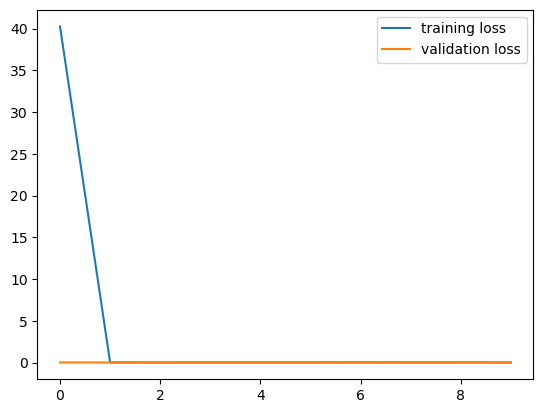

In [ ]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

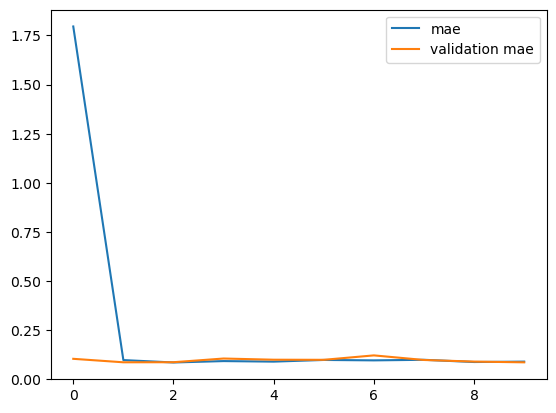

In [ ]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [ ]:
import os
import glob


predict_path = "dataset\\predict\\"

files = glob.glob(predict_path+'\\0\\*')
for f in files:
    os.remove(f)

true_y = dFTest['target'].values
print(len(true_y))
#index = np.where(true_y == true_y.max())[0][0]
#print(index)
#if index != 0:
#    indexRange = range(index-1,index+2)
#else:
#    indexRange = range(0,index+3)
#for a in indexRange:
#    img = Image.fromarray(test_setX[a,:,:])
#    img.save(predict_path+'\\0\\'+str(a)+'.tiff')


for a in range(len(true_y)):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(predict_path+'\\0\\'+str(a)+'.tiff')

predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=inputSize)


#print(dFTest['target'])                                                  
pred_y = vgg16Model.predict(predict_data)



736
Found 736 images belonging to 1 classes.
23/23 [==============================] - 7s 283ms/step


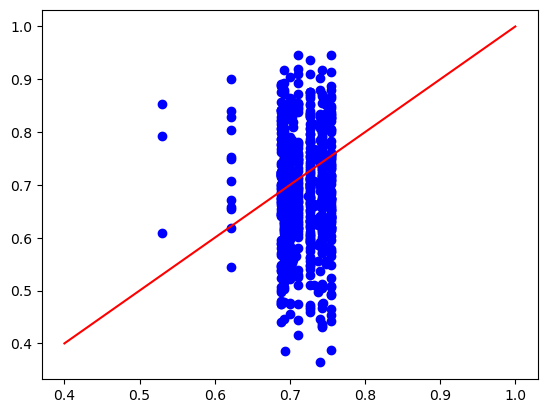

In [ ]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()


# Salviamo e carichiamo i risultati

In [76]:
'''import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)'''

'import json, codecs\nwith open("previsioneResa.json","w") as f:\n    json.dump(hist_vgg16.history, f)'

In [77]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [78]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [79]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [80]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)
vgg19Model.add(Flatten())

In [81]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [82]:
# Last layer
vgg19Model.add(Dense(512,activation='relu'))
vgg19Model.add(Dense(1,activation='sigmoid'))

In [83]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,287,553
Trainable params: 263,169
Non-trainable params: 20,024,384
_________________________________________________________________


In [84]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "adam",
             metrics = ["mse","mae"])

# Addestramento

In [85]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 20,
                               validation_data = test_data
                               )

Epoch 1/20
23/23 [==============================] - 6s 221ms/step - loss: 0.0337 - mse: 0.0337 - mae: 0.1477 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0956
Epoch 2/20
23/23 [==============================] - 5s 200ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1262 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1100
Epoch 3/20
23/23 [==============================] - 5s 201ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.1145 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.1007
Epoch 4/20
23/23 [==============================] - 5s 203ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.1110 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.1068
Epoch 5/20
23/23 [==============================] - 5s 201ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.1023 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.1158
Epoch 6/20
23/23 [==============================] - 5s 202ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.1066 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.1152
Epoch 7/20
23/23

# Visualizziamo i risultati ottenuti

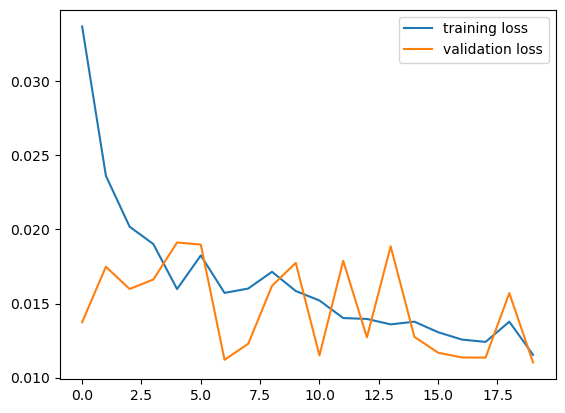

In [86]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

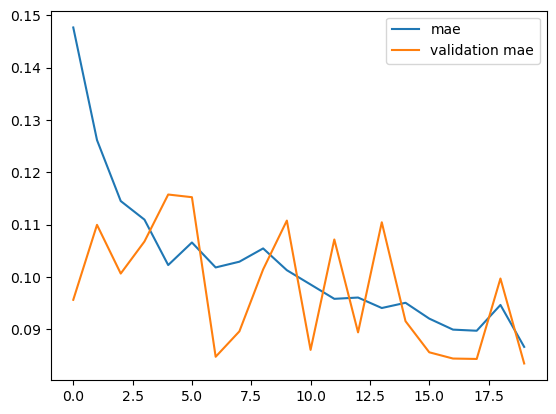

In [87]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [88]:
val = dFTest['target'].values
print(len(val))
print(np.where(val == 1.0))

736
(array([706], dtype=int64),)


Found 3 images belonging to 1 classes.
711    0.700750
712    0.796647
713    0.707547
Name: target, dtype: float32
0.689852774143219
1/1 [==============================] - 0s 62ms/step
[[0.6904471 ]
 [0.6938455 ]
 [0.68885183]]
